**lista de import**
- ! pip install scikit-image opencv-python numpy

In [ ]:
from numpy import mean
from numpy import std
import numpy as np
from skimage import color, io
import cv2
import os
import matplotlib.pyplot as plt
import itertools
import 

**Tratamento de dados**

In [5]:
rout_high = './data/high'
rout_low = './data/low'

def load_img(rout): #funcao para ler os arquivos dentro do dataset
    data_img = []
    for name in os.listdir(rout):
        rout_package = os.path.join(rout,name)
        img = cv2.imread(rout_package)
        data_img.append(img)
    return data_img

data_low = load_img(rout_low)
data_high = load_img(rout_high)


***Funções a serem utilizadas no projeto***

In [ ]:
def global_histogram_equalization(image):
     #funcao precisa separar os canais e depois mesclar para o resultado final

    r,g,b = cv2.split(image)

    r_eq = cv2.equalizeHist(r)
    g_eq = cv2.equalizeHist(g)
    b_eq = cv2.equalizeHist(b)

    image_equalize = cv2.merge((r_eq,g_eq,b_eq))
    return image_equalize

def adaptive_histogram_equalization(image, clip_limit=2.0, tile_grid_size=(8, 8)):
     #funcao precisa separar os canais e depois mesclar para o resultado final
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    r,g,b = cv2.split(image)

    r_eq = clahe.apply(r)
    g_eq = clahe.apply(g)
    b_eq = clahe.apply(b)
    
    image_equalize = cv2.merge((r_eq,g_eq,b_eq))
    
    return image_equalize

def logarithmic_transformation(image, c=500.5): #funcao nao precisa de alteração
    """
    Aplica transformação logarítmica em uma imagem para realce de detalhes em áreas escuras.

    Args:
        image: numpy array representando a imagem de entrada em escala de cinza.
        c: Constante multiplicativa para ajustar a intensidade.

    Returns:
        numpy array da imagem transformada logaritmicamente.
    """
    # Converter a imagem para float para evitar truncamento durante a transformação
    image_float = image.astype(np.float32)

    # Aplicar a transformação logarítmica
    log_image = c * np.log1p(image_float)  # log1p calcula log(1 + x) para estabilidade numérica

    # Normalizar para o intervalo [0, 255]
    log_image = cv2.normalize(log_image, None, 0, 255, cv2.NORM_MINMAX)

    # Converter de volta para uint8
    return log_image.astype(np.uint8)

def gamma_correction(image, gamma=1.0):
    """
    Aplica correção de gamma em uma imagem para ajustar os níveis de brilho.

    Args:
        image: numpy array representando a imagem de entrada em escala de cinza ou RGB.
        gamma: Valor do gamma para ajuste. Valores gamma < 1 aumentam o brilho,
               valores gamma > 1 reduzem o brilho.

    Returns:
        numpy array da imagem corrigida com gamma.
    """
    # Normalizar a imagem para o intervalo [0, 1]
    image_normalized = image / 255.0

    # Aplicar a transformação gamma
    corrected_image = np.power(image_normalized, gamma)

    # Escalar de volta para [0, 255]
    corrected_image = (corrected_image * 255).astype(np.uint8)

    return corrected_image

def bilateral_filter(image, diameter=15, sigma_color=75, sigma_space=75):
    """
    Aplica filtro bilateral em uma imagem para suavizar enquanto preserva bordas.

    Args:
        image: numpy array representando a imagem de entrada (escala de cinza ou RGB).
        diameter: Diâmetro dos pixels vizinhos considerados para filtragem.
        sigma_color: Desvio padrão no espaço de cores.
        sigma_space: Desvio padrão no espaço de coordenadas.

    Returns:
        numpy array da imagem filtrada bilateralmente.
    """
    return cv2.bilateralFilter(image, d=diameter, sigmaColor=sigma_color, sigmaSpace=sigma_space)

def adaptive_filter(image, kernel_size=5, sigma_color=75, sigma_space=75):
    """
    Aplica um filtro bilateral adaptativo manualmente, calculando o filtro bilateral
    em blocos da imagem para ajustar características locais.

    Args:
        image: numpy array representando a imagem de entrada (escala de cinza).
        kernel_size: Tamanho do kernel usado para dividir a imagem em blocos.
        sigma_color: Desvio padrão no espaço de cores.
        sigma_space: Desvio padrão no espaço de coordenadas.

    Returns:
        numpy array da imagem filtrada adaptativamente.
    """
    # Certifique-se de que a imagem está em escala de cinza
    if len(image.shape) == 3:
        raise ValueError("A imagem para o filtro adaptativo deve estar em escala de cinza.")

    # Obter dimensões da imagem
    h, w = image.shape

    # Inicializar a imagem de saída
    output = np.zeros_like(image, dtype=np.float32)

    # Aplicar filtro bilateral por blocos
    for i in range(0, h, kernel_size):
        for j in range(0, w, kernel_size):
            # Determinar os limites do bloco
            i_end = min(i + kernel_size, h)
            j_end = min(j + kernel_size, w)

            # Extrair bloco
            block = image[i:i_end, j:j_end]

            # Aplicar filtro bilateral no bloco
            filtered_block = cv2.bilateralFilter(block, d=-1, sigmaColor=sigma_color, sigmaSpace=sigma_space)

            # Colocar o bloco filtrado na imagem de saída
            output[i:i_end, j:j_end] = filtered_block

    return np.clip(output, 0, 255).astype(np.uint8)




def single_scale_retinex(image, sigma=30):
    """
    Aplica o método Single Scale Retinex (SSR) para compensação de luminosidade.

    Args:
        image: numpy array representando a imagem em escala de cinza.
        sigma: Desvio padrão do filtro Gaussiano.

    Returns:
        numpy array da imagem processada pelo SSR.
    """
    # Convertendo para float para evitar problemas de precisão
    image = image.astype(np.float32) + 1.0

    # Aplicando filtro Gaussiano
    gaussian = cv2.GaussianBlur(image, (0, 0), sigma)

    # Calculando o SSR
    retinex = np.log10(image) - np.log10(gaussian + 1e-6)

    return cv2.normalize(retinex, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def multi_scale_retinex(image, scales=[15, 80, 250]):
    """
    Aplica o método Multi-Scale Retinex (MSR) para compensação de luminosidade.

    Args:
        image: numpy array representando a imagem em escala de cinza.
        scales: Lista de desvios padrão para os diferentes filtros Gaussianos.

    Returns:
        numpy array da imagem processada pelo MSR.
    """
    # Convertendo para float para evitar problemas de precisão
    image = image.astype(np.float32) + 1.0

    # Calculando MSR combinando diferentes escalas
    retinex = np.zeros_like(image, dtype=np.float32)
    for sigma in scales:
        gaussian = cv2.GaussianBlur(image, (0, 0), sigma)
        retinex += np.log10(image) - np.log10(gaussian + 1e-6)

    retinex = retinex / len(scales)  # Média das escalas

    return cv2.normalize(retinex, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def enhance_colors(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Realça as cores de uma imagem para melhorar a qualidade visual após compensação de luminosidade.

    Args:
        image: numpy array representando a imagem de entrada (em RGB).
        clip_limit: Limite de contraste para CLAHE (Equalização Adaptativa).
        tile_grid_size: Tamanho da grade para dividir a imagem no CLAHE.

    Returns:
        numpy array da imagem com cores realçadas.
    """
    # Converter imagem de RGB para o espaço LAB
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Separar os canais L, A, B
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Aplicar CLAHE no canal L (luminosidade)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_l_channel = clahe.apply(l_channel)

    # Combinar os canais novamente
    enhanced_lab_image = cv2.merge((enhanced_l_channel, a_channel, b_channel))

    # Converter de volta para RGB
    enhanced_image = cv2.cvtColor(enhanced_lab_image, cv2.COLOR_LAB2RGB)

    return enhanced_image

def color_correction(image, intensity=1.0):
    """
    Aplica correção de cores a uma imagem, ajustando o contraste com base no histograma.

    Args:
        image: numpy array representando a imagem de entrada (em RGB ou escala de cinza).
        intensity: Float que controla o nível de intensidade do ajuste (valor padrão é 1.0).

    Returns:
        numpy array representando a imagem com a correção de cor aplicada.
    """
    # Dividir a imagem nos canais de cor (R, G, B ou equivalente em escala de cinza)
    channels = cv2.split(image)
    results = []

    # Determinar a saturação com base na intensidade
    saturation = channels[0].shape[0] * channels[0].shape[1] * intensity / 500.0

    for channel in channels:
        # Calcular o histograma do canal
        histogram = cv2.calcHist([channel], [0], None, [256], [0, 256], accumulate=False)

        # Determinar os valores lowvalue e highvalue para a correção de contraste
        low_value = np.searchsorted(np.cumsum(histogram), saturation)
        high_value = 255 - np.searchsorted(np.cumsum(histogram[::-1]), saturation)

        # Criar a LUT (Look-Up Table) para o ajuste linear
        lut = np.array([
            0 if i < low_value else
            (255 if i > high_value else
             round((i - low_value) / (high_value - low_value) * 255))
            for i in np.arange(0, 256)
        ], dtype="uint8")

        # Aplicar a LUT ao canal
        corrected_channel = cv2.LUT(channel, lut)
        results.append(corrected_channel)

    # Combinar os canais corrigidos novamente
    corrected_image = cv2.merge(results)

    return corrected_image

def sharpen_with_mask(image, kernel=(5, 5), sigma=0.5, intensity=1.0, threshold=0):
    """
    Aplica uma máscara de nitidez à imagem para melhorar detalhes e bordas.

    Args:
        image: numpy array representando a imagem de entrada (em escala de cinza ou RGB).
        kernel: Tuple definindo o tamanho do kernel da suavização Gaussiana.
        sigma: Float indicando o desvio padrão usado na suavização Gaussiana.
        intensity: Float que controla o nível de nitidez aplicado à imagem.
        threshold: Valor limite para preservar regiões de baixo contraste.

    Returns:
        numpy array representando a imagem com a máscara de nitidez aplicada.
    """
    # Aplicar suavização Gaussiana
    smoothed = cv2.GaussianBlur(image, kernel, sigma)

    # Calcular a máscara de nitidez
    sharpness = float(intensity + 1) * image - float(intensity) * smoothed

    # Garantir que os valores estejam no intervalo válido [0, 255]
    sharpness = np.maximum(sharpness, np.zeros(sharpness.shape))
    sharpness = np.minimum(sharpness, 255 * np.ones(sharpness.shape))
    sharpness = sharpness.round().astype(np.uint8)

    # Aplicar limiar opcional para preservar áreas de baixo contraste
    if threshold > 0:
        low_contrast_mask = np.absolute(image - smoothed) < threshold
        np.copyto(sharpness, image, where=low_contrast_mask)

    return sharpness

485


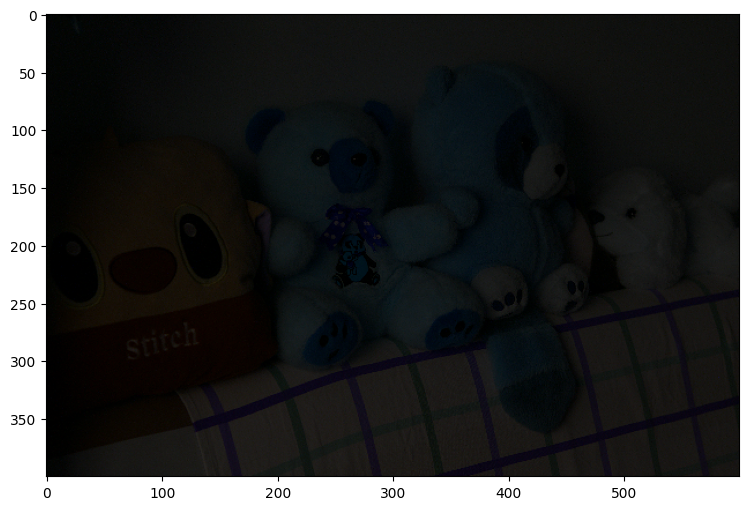

In [130]:
plt.figure(figsize=(12, 6))
print(len(data_low))

plt.imshow(sharpen_with_mask(data_low[0]))

In [133]:
list_parameters_adaptive_equalization_cliplimit= [0.5,1,1.5,2]
list_parameters_adaptive_equalization_gride_size= [(2,2),(4,4),(8,8),(16,16),(64,64)]

list_parameters_logarithmic_transformation_c = [0.1,0.5,1,2,4,8]

list_parameters_gamma_correction_gama=[0.05,0.1,0.2,0.4,0.6,0.8,1,4]

list_parameters_bilateral_filter_diameter = [1,2,4,8,16,32,64]
list_parameters_bilateral_filter_sigma_color=  [1,2,4,8,16,32,64]
list_parameters_bilateral_filter_sigma_space =  [1,2,4,8,16,32,64]

list_parameters_single_scale_retinex_sigma = [30,64,128,256,512]

list_parameters_multi_scale_retinex=[[3,40,75],[6,60,125],[15,80,250],[30,160,500]]

list_parameters_enhance_colors_clip = [2,4,8,16,32]
list_parameters_enhance_colors_grid = [(4,4),(8,8),(16,16)]

list_parameters_color_correction_intensity = [1,8,16,32,64,128]

list_parameters_sharpen_with_mask_kernel = [(2,2),(4,4),(8,8),(16,16)] 


